In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [ ]:
train_data_dir = '/kaggle/working/train'
val_data_dir = '/kaggle/working/val'
test_data_dir = '/kaggle/working/test'

img_height, img_width = 224, 224
batch_size = 32
num_classes = 488 

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    channel_shift_range=50.0,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# `Load datasets`

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 31921 images belonging to 488 classes.
Found 4238 images belonging to 488 classes.
Found 3988 images belonging to 488 classes.


In [6]:
# Load EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False 

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Build model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x) 
predictions = Dense(num_classes, activation='softmax')(x)

In [8]:
model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [11]:
# Fix steps to avoid running out of data
steps_per_epoch = max(1, len(train_generator))
validation_steps = max(1, len(val_generator))
test_steps = max(1, len(test_generator))

In [12]:
# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/10


998/998 ━━━━━━━━━━━━━━━━━━━━ 1910s 2s/step - accuracy: 0.0024 - loss: 6.1914 - val_accuracy: 0.0031 - val_loss: 6.1671 - learning_rate: 0.0010
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 1884s 2s/step - accuracy: 0.0030 - loss: 6.1723 - val_accuracy: 0.0031 - val_loss: 6.1641 - learning_rate: 0.0010
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 68us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 1873s 2s/step - accuracy: 0.0026 - loss: 6.1664 - val_accuracy: 0.0031 - val_loss: 6.1680 - learning_rate: 0.0010
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 59us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 1875s 2s/step - accuracy: 0.0027 - loss: 6.1659 - val_accuracy: 0.0031 - val_loss: 6.1635 - learning_rate: 0.0010
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━

In [13]:
# Save trained model
model.save('EfficientNetB0.h5')

# `Test Performance`

In [14]:
# Get final accuracy
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

# Evaluate on test set
test_loss, final_test_acc = model.evaluate(test_generator, steps=test_steps)

125/125 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.0035 - loss: 6.1490


In [15]:
# Print results
print("\nEfficientNetB0 Results:")
print(f"Final Train Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Test Accuracy: {final_test_acc:.4f}\n")



EfficientNetB0 Results:
Final Train Accuracy: 0.0212
Final Validation Accuracy: 0.0331
Final Test Accuracy: 0.0312



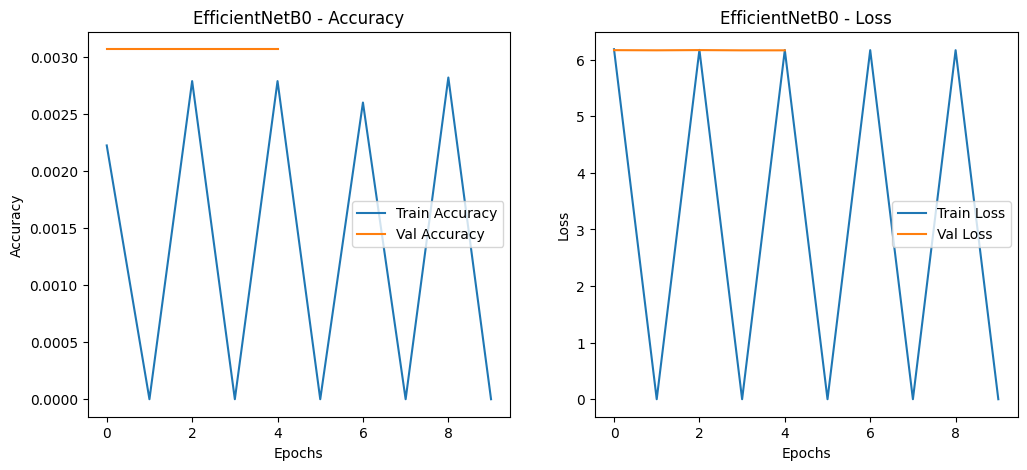

In [16]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('EfficientNetB0 - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('EfficientNetB0 - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()